<a href="https://colab.research.google.com/github/its-rajesh/Music-Speech-Separation/blob/main/MSClassifierV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MUSIC SPEECH CONV NEURAL NETWORK CLASSIFIER**

### **Imports**

In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
import soundfile as sf
import librosa as lb
import numpy as np
from matplotlib import pyplot as plt
import os
import pandas as pd

### **Reading audio files and creating chunks**

In [3]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [76]:
'''
THIS FUNCTION ACCEPTS FOLDER PATH WHICH CONTAINS SPEECH AND MUSIC DATASET
RETURNS: 1D ARRAY OF AUDIO FILES
'''
def readaudiofiles(path):

  folders = os.listdir(path)
  print(folders)

  audiofiles = []
  for folder in folders:
    files = os.listdir(path+'/'+folder)
    files = sorted(files)
    audio = []
    for file in files:
        data, samplerate = lb.load(path+'/'+folder+'/'+file, sr=8000, mono=True)
        audio.append(data)
    audiofiles.append(audio)

  music = np.array(audiofiles[3])
  mixture = np.array(audiofiles[0])
  overlay = np.array(audiofiles[1])
  speech = np.array(audiofiles[2])

  dataset = [music, mixture, overlay, speech]
  print(samplerate)

  return music, mixture, overlay, speech, dataset


path = '/drive/My Drive/Projects/Music-Speech-Separation/Dataset/'
music, mixture, overlay, speech, dataset = readaudiofiles(path)

['Mixture', 'Overlay', 'speech', 'music']
8000


In [77]:
music[0], len(music[0]), len(music[0])/8000

(array([-0.06211764, -0.17527802, -0.13408872, ...,  0.06697536,
         0.07972796,  0.11764227], dtype=float32), 120000, 15.0)

In [78]:
'''
THIS FUNCTION CREATES CHUNCKS OF THE GIVEN AUDIO FILE
INPUTS: AUDIO (Can change the chunks length in seconds as indicated)
RETURNS: CHUNCKS
'''
def createchunks(audio):
  start = 0
  stop = 4000 # for 0.5 seconds (8Khz): 1 sec has 8000 samples.
  chunks = []
  for i in range(len(audio)//4000):
    chunks.append(audio[start:stop])
    start = stop
    stop = start+4000

  return chunks

### **Obtaining STFT features**

In [79]:
def stft_extract(music, speech):
  datasetstft = []
  index = 0
  y_train = []
  for data in [music, speech]:
      spect = []
      y = []
      for audio in data:
        chunks = np.array(createchunks(audio))
        chunks_spect = []
        for i in chunks:
          chunks_spect.append(np.abs(lb.stft(i,n_fft=512))) #window length = nfft and hop length = win length //4

        chunks_spect = np.array(chunks_spect)

        spect.append(chunks_spect)

        if index == 0:
          y.append(np.zeros(30))
        elif index == 1:
          y.append(np.ones(30))
      
      index += 1
      y_train.append(np.array(y))
      datasetstft.append(np.array(spect))

  return datasetstft, y_train

In [80]:
datasetstft, y_train_stft = stft_extract(music, speech)

In [81]:
y_train_stft[0].shape, len(y_train_stft)

((50, 30), 2)

In [82]:
datasetstft[0].shape, len(datasetstft)

((50, 30, 257, 32), 2)

### **Obtaining chroma features**

In [85]:
def chroma_extract(music, speech):
  datasetchroma = []
  index = 0
  y_train = []
  for data in [music, speech]:
      spect = []
      y = []
      for audio in data:
        chunks = np.array(createchunks(audio))
        chunks_spect = []
        for i in chunks:
          chunks_spect.append(lb.feature.chroma_stft(y=audio))

        chunks_spect = np.array(chunks_spect)

        spect.append(chunks_spect)

        if index == 0:
          y.append(np.zeros(30))
        elif index == 1:
          y.append(np.ones(30))
      
      index += 1
      y_train.append(np.array(y))
      datasetchroma.append(np.array(spect))

  return datasetchroma, y_train

In [86]:
datasetchroma, y_train_chroma = chroma_extract(music, speech)

In [87]:
y_train_chroma[0].shape, len(y_train_chroma)

((50, 30), 2)

In [88]:
datasetchroma[0].shape, len(datasetchroma)

((50, 30, 12, 235), 2)

### **Reshaping the training datasets**

In [89]:
def reshape_dataset(trainD):
  X_TRAIN = []
  for data in trainD:
    for i in data:
      for j in i:
        X_TRAIN.append(j)

  return np.array(X_TRAIN)

In [109]:
def reshape_y(y_train):
  Y_TRAIN = []
  for val in y_train:
    for i in val:
      for j in i:
        Y_TRAIN.append(j)

  return np.array(Y_TRAIN)

**STFT FEATURES AS TRAINING**

In [121]:
X_TRAIN = reshape_dataset(datasetstft)
Y_TRAIN = reshape_y(y_train_stft)

X_TRAIN.shape, Y_TRAIN.shape

((3000, 257, 32), (3000,))

**CHROMA FEATURES AS TRAINING**

In [111]:
X_TRAIN = reshape_dataset(datasetchroma)
Y_TRAIN = reshape_y(y_train_chroma)

X_TRAIN.shape, Y_TRAIN.shape

((3000, 12, 235), (3000,))

### **Test data preparation**

In [101]:
'''
THIS FUNCTION ACCEPTS FOLDER PATH WHICH CONTAINS SPEECH AND MUSIC DATASET
RETURNS: 1D ARRAY OF AUDIO FILES
'''
def readaudiofiles(path):

  folders = os.listdir(path)
  print(folders)

  audiofiles = []
  for folder in folders:
    files = os.listdir(path+'/'+folder)
    files = sorted(files)
    audio = []
    for file in files:
        data, samplerate = lb.load(path+'/'+folder+'/'+file, sr=8000, mono=True)
        audio.append(data)
    audiofiles.append(audio)

  music = np.array(audiofiles[1])
  mixture = np.array(audiofiles[2])
  overlay = np.array(audiofiles[3])
  speech = np.array(audiofiles[0])

  dataset = [music, mixture, overlay, speech]
  print(samplerate)

  return music, mixture, overlay, speech, dataset

In [102]:
test_path = '/drive/My Drive/Projects/Music-Speech-Separation/Test Dataset/'

music_test, mixture_test, overlay_test, speech_test, dataset_test = readaudiofiles(test_path)

print(music_test[0], len(music_test[0]), len(music_test[0])/8000)

['speech', 'music', 'mixture', 'overlay']
8000
[-0.06551269 -0.09722305 -0.09252059 ... -0.0058487   0.04005643
  0.08765063] 120000 15.0


In [103]:
dataset_test_stft, y_test_stft = stft_extract(music_test, speech_test)
print(dataset_test_stft[0].shape, len(dataset_test_stft))

(10, 30, 257, 32) 2


In [104]:
dataset_test_chroma, y_test_chroma = chroma_extract(music_test, speech_test)
print(dataset_test_chroma[0].shape, len(dataset_test_chroma))

(10, 30, 12, 235) 2


**TEST STFT FEATURES**

In [122]:
X_TEST = reshape_dataset(dataset_test_stft)
Y_TEST = reshape_y(y_test_stft)

X_TEST.shape, Y_TEST.shape

((600, 257, 32), (600,))

**TEST CHROMA FEATURES**

In [113]:
X_TEST = reshape_dataset(dataset_test_chroma)
Y_TEST = reshape_y(y_test_chroma)

X_TEST.shape, Y_TEST.shape

((600, 12, 235), (600,))

# **CNN MODEL**

In [115]:
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout,Conv2D,MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [123]:
batch_size = 32
epochs = 50
inp = Input(shape =(257, 32, 1))
out_dim = 2

In [124]:
start = time.time()

x = Conv2D(32, 3, activation='relu')(inp)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.30)(x)

x = Conv2D(64, 3, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.30)(x)

x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = Dropout(0.30)(x)

x = Dense(out_dim, activation='softmax')(x)

In [125]:
x_train = X_TRAIN
y_train = Y_TRAIN

In [126]:
classify = Model(inputs = inp, outputs = x)
classify.compile(loss='SparseCategoricalCrossentropy', optimizer = 'adam', metrics='accuracy') 
#classify.summary()
classify_train = classify.fit(x_train,y_train, epochs = epochs ,batch_size=batch_size)
end = time.time()
print("time taken",time)

Epoch 1/50
94/94 [==============================] - 41s 427ms/step - loss: 0.6503 - accuracy: 0.8630
Epoch 2/50
94/94 [==============================] - 40s 428ms/step - loss: 0.1295 - accuracy: 0.9523
Epoch 3/50
94/94 [==============================] - 40s 430ms/step - loss: 0.0829 - accuracy: 0.9707
Epoch 4/50
94/94 [==============================] - 40s 428ms/step - loss: 0.0547 - accuracy: 0.9843
Epoch 5/50
94/94 [==============================] - 40s 427ms/step - loss: 0.0651 - accuracy: 0.9810
Epoch 6/50
94/94 [==============================] - 40s 429ms/step - loss: 0.0449 - accuracy: 0.9857
Epoch 7/50
94/94 [==============================] - 41s 432ms/step - loss: 0.0356 - accuracy: 0.9907
Epoch 8/50
94/94 [==============================] - 41s 431ms/step - loss: 0.0269 - accuracy: 0.9900
Epoch 9/50
94/94 [==============================] - 40s 430ms/step - loss: 0.0282 - accuracy: 0.9917
Epoch 10/50
94/94 [==============================] - 40s 431ms/step - loss: 0.0238 - accura

In [127]:
test_eval = classify.evaluate(X_TEST,  Y_TEST, verbose=0)
print('Test', test_eval)

Test [0.2637518644332886, 0.95333331823349]


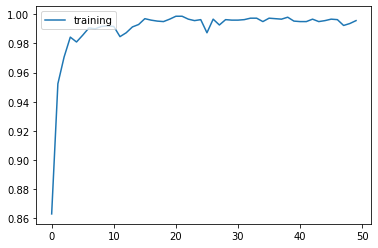

In [128]:
plt.plot(classify_train.history['accuracy'])
plt.legend(['training'], loc = 'upper left')
plt.show()

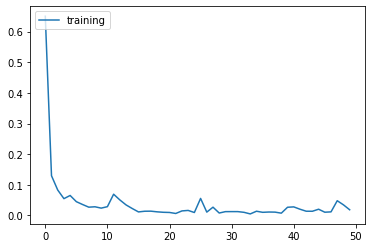

In [129]:
plt.plot(classify_train.history['loss'])
plt.legend(['training'], loc = 'upper left')
plt.show()

In [130]:
predictions = classify.predict(X_TEST, verbose=1)
result = np.argmax(predictions, axis=1)
result

19/19 [==============================] - 2s 92ms/step


array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [131]:
cm = tf.math.confusion_matrix(Y_TEST, result)
cm

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[275,  25],
       [  3, 297]], dtype=int32)>

# **TEST ON AIR DATA**

In [162]:
sample_audio, sr  = lb.load('/drive/My Drive/Projects/Music-Speech-Separation/kannada.wav', sr=8000, mono=True)
sample_audio, sr

(array([0.        , 0.        , 0.        , ..., 0.11099157, 0.09802414,
        0.        ], dtype=float32), 8000)

In [163]:
chunks_sample = np.array(createchunks(sample_audio))
spect_sample = []
for i in chunks_sample:
  spect_sample.append(np.abs(lb.stft(i,n_fft=512))) #window length = nfft and hop length = win length //4

spect_sample = np.array(spect_sample)
spect_sample.shape

(629, 257, 32)

In [164]:
res = classify.predict(spect_sample)
res = np.argmax(res, axis=1)
res

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [165]:
len(res)

629

### **DELETING MUSIC FROM SPEECH**

In [180]:
seconds = 0
time_split = []
for i in range(len(res)):
  seconds += 0.5
  if res[i] == 1:
    time_split.append(seconds)

print(time_split)

[0.5, 13.5, 14.0, 14.5, 15.0, 15.5, 16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 19.0, 19.5, 20.0, 20.5, 21.0, 21.5, 22.0, 22.5, 23.0, 23.5, 24.0, 24.5, 25.0, 25.5, 26.0, 26.5, 27.0, 27.5, 28.0, 28.5, 29.0, 29.5, 30.0, 30.5, 31.0, 31.5, 32.0, 32.5, 33.0, 33.5, 34.0, 34.5, 35.0, 35.5, 36.0, 36.5, 37.0, 37.5, 38.0, 38.5, 39.0, 39.5, 40.0, 40.5, 41.0, 41.5, 42.0, 42.5, 43.0, 43.5, 44.0, 44.5, 45.0, 45.5, 46.0, 46.5, 47.0, 47.5, 48.0, 48.5, 49.0, 49.5, 50.0, 50.5, 51.0, 51.5, 52.0, 52.5, 53.0, 53.5, 54.0, 54.5, 55.0, 55.5, 56.0, 56.5, 57.0, 57.5, 58.0, 58.5, 59.0, 59.5, 60.0, 60.5, 61.0, 61.5, 62.0, 62.5, 63.0, 63.5, 64.0, 64.5, 65.0, 65.5, 66.0, 66.5, 67.0, 67.5, 68.0, 68.5, 69.0, 69.5, 70.0, 70.5, 71.0, 71.5, 72.0, 72.5, 73.0, 73.5, 74.0, 74.5, 75.0, 75.5, 76.0, 76.5, 77.0, 77.5, 78.0, 78.5, 79.0, 79.5, 80.0, 80.5, 81.0, 81.5, 82.0, 82.5, 83.0, 83.5, 84.0, 84.5, 85.0, 85.5, 86.0, 86.5, 87.0, 87.5, 88.0, 88.5, 89.0, 89.5, 90.0, 90.5, 91.0, 91.5, 92.0, 92.5, 93.0, 93.5, 94.0, 94.5, 95.0, 95.5, 96.0

In [181]:
time_index = []
time_index.append(time_split[0])
for i in range(len(time_split)-1):
  if time_split[i+1] != time_split[i]+0.5:
    time_index.append(time_split[i])
    time_index.append(time_split[i+1])

time_index.append(time_split[-1])
time_index

[0.5, 0.5, 13.5, 302.5]

In [187]:
time_tuple = []
for i in range(0, len(time_index)-1, 2):
  if time_index[i] != 0 and time_index[i] != 0.5:
    time_tuple.append(((time_index[i])*1000, (time_index[i+1])*1000)) #converting into msec
  else:
    time_tuple.append(((time_index[i])*1000, (time_index[i+1])*1000))

time_tuple

[(500.0, 500.0), (13500.0, 302500.0)]

In [153]:
seconds = [(500.0, 500.0), (13500.0, 302500.0)]

In [ ]:
sample_audio = AudioSegment.from_file("/home/rajesh/Desktop/kannada.wav", format="wav")

trimmed_audio = []
for sec in seconds:
    trimmed_audio.append(sample_audio[int(sec[0]):int(sec[1])])


extracted = trimmed_audio[0]
for i in range(1, len(trimmed_audio)):
    extracted = extracted+trimmed_audio[i]


extracted.export("/home/rajesh/Desktop/speechextractedkannada.wav", format="wav")

